In [51]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importing Python Packages

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re

In [53]:
nlp = spacy.load('en_core_web_sm')

## Reading and Exploring Data

In [54]:
df = pd.read_csv("/content/gdrive/MyDrive/Practice Projects/Spam-Ham Classifier/Data/smsspamcollection.tsv", sep="\t")
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [55]:
# Data Size
print(f"Initially, We have {len(df)} examples")

Initially, We have 5572 examples


In [56]:
# Check Null Data
print(df.isnull().sum())

label      0
message    0
length     0
punct      0
dtype: int64


In [57]:
# Check empty Data
empty_rows = []
for i, msg in df[['message']].itertuples():
  if len(msg) < 1:
    empty_rows.append(i)

len(df.loc[empty_rows])

0

In [58]:
# Count examples in each class
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

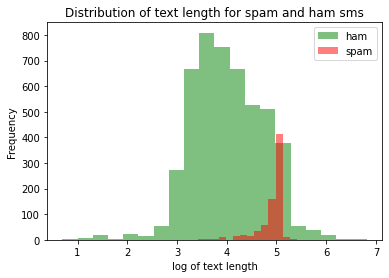

In [59]:
# Visualizing the relation between length of the text and text being spam or ham
plt.hist(np.log(df[df['label'] == "ham"]['length']), bins=20, color="green", alpha=0.5, label="ham");
plt.hist(np.log(df[df['label'] == "spam"]['length']), bins=20, color="red", alpha=0.5, label="spam");
plt.xlabel("log of text length");
plt.ylabel("Frequency");
plt.title("Distribution of text length for spam and ham sms");
plt.legend()
plt.show()

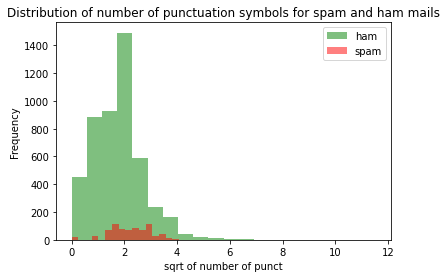

In [60]:
# Visualizing the relation between number of punc symbols and text being spam or ham
plt.hist(np.sqrt(df[df['label'] == "ham"]['punct']), bins=20, color="green", alpha=0.5, label="ham");
plt.hist(np.sqrt(df[df['label'] == "spam"]['punct']), bins=20, color="red", alpha=0.5, label="spam");
plt.xlabel("sqrt of number of punct");
plt.ylabel("Frequency");
plt.title("Distribution of number of punctuation symbols for spam and ham mails");
plt.legend()
plt.show()

## Text Preprocessing

In [61]:
def clean_text(text):
  pattern_s = re.compile(r"\'s")
  pattern_nonalpha = re.compile(r"[^\w\s]")
  pattern_n = re.compile("\\r\\n") 

  text = text.lower()
  text = re.sub(pattern_s, "", text)
  text = re.sub(pattern_nonalpha, "", text)
  text = re.sub(pattern_n, "", text)

  return text

df['message_cleaned'] = df.message.apply(clean_text)

In [62]:
df['message_doc'] = df.message_cleaned.apply(lambda x : nlp(x))

### Normalizing

In [63]:
stop_words = nlp.Defaults.stop_words
df['message_normalized'] = df.message_doc.apply(lambda text: " ".join([w.lemma_ for w in text if w.text not in stop_words]))
df

,label,message,length,punct,message_cleaned,message_doc,message_normalized
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,go until jurong point crazy available only in ...,"(go, until, jurong, point, crazy, available, o...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joking wif u oni,"(ok, lar, joking, wif, u, oni)",ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,free entry in 2 a wkly comp to win fa cup fina...,"(free, entry, in, 2, a, wkly, comp, to, win, f...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,6,u dun say so early hor u c already then say,"(u, dun, say, so, early, hor, u, c, already, t...",u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,nah i dont think he goes to usf he lives aroun...,"(nah, i, do, nt, think, he, goes, to, usf, he,...",nah not think go usf live
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,8,this is the 2nd time we have tried 2 contact u...,"(this, is, the, 2nd, time, we, have, tried, 2,...",2nd time try 2 contact u u win 750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,36,1,will ü b going to esplanade fr home,"(will, ü, b, going, to, esplanade, fr, home)",ü b go esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,7,pity was in mood for that soany other suggest...,"(pity, , was, in, mood, for, that, soany, oth...",pity mood soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,125,1,the guy did some bitching but i acted like id ...,"(the, guy, did, some, bitching, but, i, acted,...",guy bitching act like d interested buy week gi...


## Splitting Data

In [64]:
# Define Features and Labels
X = df['message']
y = df['label']

In [65]:
# leave 30% of examples as test data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Model Pipeline

Performing two steps in the pipeline:
- Vectorization using tf-idf.
- Fitting Classification model using Linear SVC

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

clf.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

## Evaluation on Test Data

In [67]:
predictions = clf.predict(x_test)

In [68]:
# classification_report
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.92      0.95       224

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



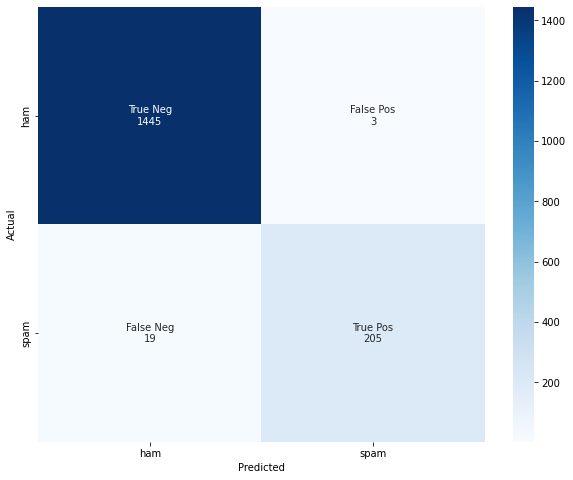

In [69]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');
plt.xlabel("Predicted");
plt.ylabel("Actual");
plt.xticks([0.5,1.5], labels=['ham', 'spam']);
plt.yticks([0.5,1.5], labels=['ham', 'spam']);
plt.show()

**From Reults**:
- 100% of actual ham sms texts have been detected successfully by the classifier.
- 99% of predicted ham sms texts were actually ham.
- 92% of actual spam sms texts have been detected successfully by the classifier.
- 99% of predicted spam sms texts were actually spam.
